In [1]:
from transformers import AutoImageProcessor, ResNetForImageClassification
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import pickle

c:\Users\user\anaconda3\envs\MAIN_ENV\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
net = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

net.classifier = torch.nn.Sequential(torch.nn.Flatten(start_dim=1, end_dim=-1),
                                     torch.nn.Linear(2048, 8))

GPU = torch.device("cuda")
net.to(GPU)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [3]:
def load_image(image_path):
    return Image.open(image_path)

In [4]:
def train_nn(question_tensor, answer_tensor, model, loss=loss, optimizer=optimizer):
    optimizer.zero_grad()
    outputs = model(question_tensor).logits
    loss = loss(outputs, answer_tensor)
    loss.backward()
    optimizer.step()
    return loss.item()

In [5]:
class ImageDataset():
    def __init__(self, main_dir):
        self.questions = []
        self.answers = []
        
        self.class_folders = os.listdir(main_dir)
        
        for x in tqdm(range(len(self.class_folders))):
            self.current_dir = os.listdir(f"{main_dir}/{self.class_folders[x]}")
            
            for y in self.current_dir:
                self.questions.append(processor(load_image(f"{main_dir}/{self.class_folders[x]}/{y}"), return_tensors="pt")["pixel_values"])
                self.answers.append(torch.eye(len(self.class_folders))[x])
    
    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        return self.questions[idx], self.answers[idx]

In [6]:
reset_datasets = False
batch_size = 45

if reset_datasets:
    print("resetting train / test datasets")
    
    train_dataset = ImageDataset(r"C:\Users\user\Desktop\AUTOENCODER\old (original injury dataset)\TRAIN")
    test_dataset = ImageDataset(r"C:\Users\user\Desktop\AUTOENCODER\old (original injury dataset)\TEST")

    with open("train_set_dump.pkl", "wb") as f:
        pickle.dump(train_dataset, f)
    
    with open("test_set_dump.pkl", "wb") as f:
        pickle.dump(test_dataset, f)
else:
    print("loading train / test datasets")
    
    with open("train_set_dump.pkl", "rb") as f:
        train_dataset = pickle.load(f)
        
    with open("test_set_dump.pkl", "rb") as f:
        test_dataset = pickle.load(f)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

loading train / test datasets


In [7]:
loss_list = []
accuracy_list = []
outer_loop_break = False  # Variable to break out of the outer loop

for y in tqdm(range(50)):
    for x in enumerate(train_loader):
        
        x[1][0] = x[1][0].to(GPU)
        x[1][1] = x[1][1].to(GPU)
        
        loss_list.append(train_nn(x[1][0][:, 0, :, :,], x[1][1], net))
            
        x[1][0] = x[1][0].cpu()
        x[1][1] = x[1][1].cpu()
        
    errors = 0
    
    for z in enumerate(test_loader):
        z[1][0] = z[1][0].to(GPU)
        z[1][1] = z[1][1].to(GPU)
        
        if torch.argmax(z[1][1][0]) != torch.argmax(net(z[1][0][0]).logits):
            errors += 1
            
        z[1][0] = z[1][0].cpu()
        z[1][1] = z[1][1].cpu()
        
    accuracy_list.append(errors)
    
    if outer_loop_break:
        break  # Breaks out of the outer loop

100%|██████████| 50/50 [1:00:47<00:00, 72.95s/it]


In [16]:
print(f"error rate: {errors / len(test_dataset) * 100}%")
print(f"success rate: {100 - errors / len(test_dataset) * 100:.03f}%")
print(f"random success rate: {1 / 7 * 100}%")

error rate: 22.291666666666668%
success rate: 77.708%
random success rate: 14.285714285714285%


In [9]:
errors = 0

for z in enumerate(test_loader):
    z[1][0] = z[1][0].to(GPU)
    z[1][1] = z[1][1].to(GPU)
    
    if torch.argmax(z[1][1][0]) != torch.argmax(net(z[1][0][0]).logits):
        errors += 1
    
    z[1][0] = z[1][0].cpu()
    z[1][1] = z[1][1].cpu()

In [10]:
errors

107

In [11]:
torch.argmin(torch.tensor(accuracy_list))

tensor(36)

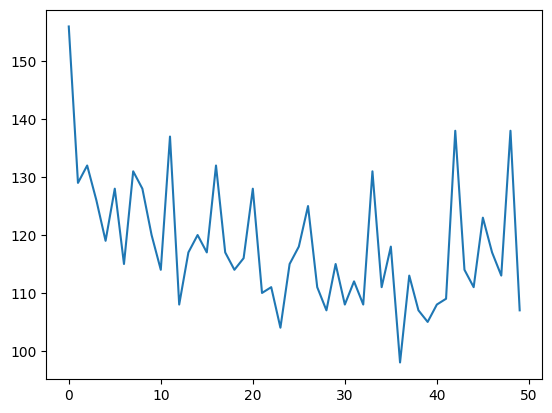

In [12]:
plt.plot(accuracy_list)

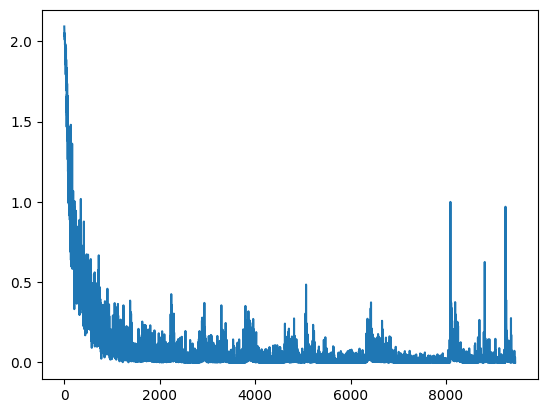

In [13]:
plt.plot(loss_list)

In [14]:
reset_model_checkpoint = False

if reset_model_checkpoint:
    torch.save(net.state_dict(), fr"main_classifier_chekpoint_8cls_{100 - errors / len(test_dataset) * 100:.03f}%acc.pth")

In [15]:
load_model_checkpoint = False

if load_model_checkpoint:
    state_dict = torch.load(r"main_classifier_chekpoint_74.166%acc.pth")
    net.load_state_dict(state_dict)